<a href="https://colab.research.google.com/github/SantosAbimaelRomero/Sales-Preditions/blob/main/Sales_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Data

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn import set_config
set_config(display='diagram')

In [2]:
df = pd.read_csv('/content/sales_predictions.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Data Prep

In [3]:
df.duplicated().sum()

0

No Duplicates

In [4]:
df.isna().sum()
# Item_Weight and Outlet_Size are missing data

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In my 'Sales Presentation' file, it can be seen how I came to the following code in detail.

Essentially I found patterns in what stores where what size and filled in the missing values accordingly for the 'Outlet_Size' column.

In [5]:
for index in range(len(df)):
    if df.loc[index, 'Outlet_Location_Type'] == 'Tier 2':
        df.loc[index, 'Outlet_Size'] = 'Small'
    elif df.loc[index, 'Outlet_Type'] == 'Grocery Store':
        df.loc[index, 'Outlet_Size'] = 'Small'
    elif df.loc[index, 'Outlet_Type'] == 'Supermarket Type2':
        df.loc[index, 'Outlet_Size'] = 'Medium'
    elif df.loc[index, 'Outlet_Type'] == 'Supermarket Type3':
        df.loc[index, 'Outlet_Size'] = 'Medium'


In [6]:
df.isna().sum()
# Item_Weight is missing data

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

I will fill the missing values in Item_Weight using SimpleImputer

## Removing Columns

In [7]:
df1 = df.drop(columns=['Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year'])

I decided to remove the above two columns as it would only clutter the data and will not provide a significant statistic for predicting total outlet sales.

## Ordinal Encoding

In [8]:
df1.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,Small,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,High,Tier 3,Supermarket Type1,994.7052


Outlet_Size can be ordinally encoded.

In [9]:
df1['Outlet_Size'].value_counts()

Small     4798
Medium    2793
High       932
Name: Outlet_Size, dtype: int64

In [10]:
df1['Outlet_Size'].replace({'Small':0, 'Medium':1, 'High':2}, inplace=True)
df1['Outlet_Size'].value_counts()

0    4798
1    2793
2     932
Name: Outlet_Size, dtype: int64

I considerd other columns, like "Outlet_Type", to also ordinally encode but have chosen against this as the categories inside this column overlap with other features. For example, a Tier 1 in "Outlet_Type" can be either small or medium but a Tier 2 can also be medium and high, while Tier 3 is all three, small, medium, and high, so I can't clearly identify a proper tier of which should come first and which last. 

# Preprocessing

## Train/Test Split

In [11]:
# Feature Matrix
X = df1.drop(columns='Item_Outlet_Sales')
# Target Vector
y = df1['Item_Outlet_Sales']

In [12]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Selectors

In [13]:
# Object Column Filter
obj_filter = make_column_selector(dtype_include='object')
# Int and Float Column Filter
num_filter = make_column_selector(dtype_include='number')

## Transformers

In [14]:
# Scaler
scaler = StandardScaler()
# One Hot Encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [15]:
# Imputers
imp_mean = SimpleImputer(strategy='median')

Why did I chose median strategy?

With the following code we can see that the two following strategies will give roughly the same answer, I chose the median because the value was the smallest, the range between smallest and highest value in this column is ~4.5 to ~21.3, a fairly large range for this type of information. So, using the lowest value will keep this column from having too many large values overall as most items in a grocery store typically don't weigh much at all.

In [16]:
print(df1['Item_Weight'].mean())
print('')
df1['Item_Weight'].median()

12.857645184135976



12.6

In [17]:
print(df1['Item_Weight'].min())
df1['Item_Weight'].max()

4.555


21.35

## Pipelines

In [18]:
# Numeric pipeline
num_pipe = make_pipeline(imp_mean, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

## ColumnTransformers

In [19]:
# Tuples for Column Transformer
num_tuple = (num_pipe, num_filter)
obj_tuple = (ohe, obj_filter)
# ColumnTransformer
preprocessor = make_column_transformer(num_tuple, obj_tuple, remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7efe75301050>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7efe75301090>)])

# Transform Data

In [20]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7efe75301050>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7efe75301090>)])

In [21]:
X_train_post = preprocessor.transform(X_train)
X_test_post = preprocessor.transform(X_test)

# Post Processing

In [22]:
X_train_viz = pd.DataFrame(X_train_post)
X_test_viz = pd.DataFrame(X_test_post)

In [23]:
print(f"""Missing values in training data:
{X_train_viz.isna().sum().sum()}
Data Type in Training data:
{X_train_post.dtype}

Missing values in test data:
{X_test_viz.isna().sum().sum()}
Data Type in Test Data:
{X_test_post.dtype}
""")

Missing values in training data:
0
Data Type in Training data:
float64

Missing values in test data:
0
Data Type in Test Data:
float64



## Training Data

In [24]:
# Post processing training numpy array
X_train_post

array([[ 0.82748547, -0.71277507,  1.82810922, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.56664432, -1.29105225,  0.60336888, ...,  0.        ,
         1.        ,  0.        ],
       [-0.12102782,  1.81331864,  0.24454056, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.12389588, -0.92052713,  1.52302674, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.77599877, -0.2277552 , -0.38377708, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82748547, -0.95867683, -0.73836105, ...,  1.        ,
         0.        ,  0.        ]])

In [25]:
# Post processing training dataframe
X_train_viz

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.827485,-0.712775,1.828109,0.668862,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.566644,-1.291052,0.603369,0.668862,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.121028,1.813319,0.244541,0.668862,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.158464,-1.004931,-0.952591,-0.799831,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.538870,-0.965484,-0.336460,-0.799831,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,-0.821742,4.309657,-0.044657,-0.799831,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
6388,0.649639,1.008625,-1.058907,-0.799831,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6389,1.123896,-0.920527,1.523027,-0.799831,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6390,1.775999,-0.227755,-0.383777,-0.799831,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [26]:
X_train_viz.describe().round(2)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,...,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00
mean,-0.00,-0.00,0.00,-0.00,0.04,0.59,0.34,0.01,0.01,0.07,...,0.14,0.05,0.02,0.27,0.33,0.40,0.12,0.65,0.11,0.11
std,1.00,1.00,1.00,1.00,0.20,0.49,0.47,0.12,0.12,0.26,...,0.35,0.22,0.14,0.45,0.47,0.49,0.33,0.48,0.31,0.32
min,-1.97,-1.29,-1.77,-0.80,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-0.80,-0.76,-0.76,-0.80,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,-0.05,-0.23,0.03,-0.80,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
75%,0.77,0.56,0.72,0.67,0.00,1.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00
max,2.01,5.13,1.99,2.14,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## Test Data

In [27]:
# Post processing test numpy array
X_test_post

array([[ 0.34137241, -0.77664625, -0.99881554, ...,  1.        ,
         0.        ,  0.        ],
       [-1.16913501,  0.1003166 , -1.58519423, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.38879808, -0.48299432, -1.59578435, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-1.12882319,  1.21832428,  1.09397975, ...,  1.        ,
         0.        ,  0.        ],
       [-1.48688696, -0.77809567, -0.36679966, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.53107507, -0.77976293,  0.11221189, ...,  1.        ,
         0.        ,  0.        ]])

In [28]:
# Post processing test dataframe
X_test_viz

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.341372,-0.776646,-0.998816,2.137555,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-1.169135,0.100317,-1.585194,-0.799831,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.388798,-0.482994,-1.595784,0.668862,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.049889,-0.415440,0.506592,0.668862,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-0.632039,-1.047426,0.886725,-0.799831,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,1.123896,-1.134688,0.473646,2.137555,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2127,-0.632039,-1.291052,0.018124,-0.799831,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2128,-1.128823,1.218324,1.093980,-0.799831,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2129,-1.486887,-0.778096,-0.366800,0.668862,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [29]:
X_test_viz.describe().round(2)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,...,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.00,2131.0
mean,-0.04,0.01,-0.06,0.01,0.03,0.61,0.33,0.01,0.01,0.08,...,0.14,0.05,0.01,0.30,0.32,0.38,0.13,0.66,0.11,0.1
std,1.01,1.04,0.98,1.01,0.16,0.49,0.47,0.11,0.12,0.27,...,0.34,0.23,0.11,0.46,0.47,0.49,0.34,0.47,0.31,0.3
min,-1.96,-1.29,-1.75,-0.80,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
25%,-0.88,-0.76,-0.78,-0.80,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
50%,-0.05,-0.24,-0.15,-0.80,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.0
75%,0.74,0.56,0.64,0.67,0.00,1.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,1.00,1.00,0.00,1.00,0.00,0.0
max,2.01,4.79,1.99,2.14,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0


# Prediction Model

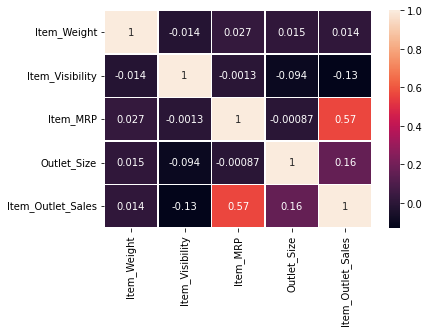

In [30]:
corr = df1.corr()
sns.heatmap(data=corr, annot=True, linewidth=0.5);

Quickly observing any correlation between the numerical data columns, the only two columns with any significant correlation is Item MRP and Item Outlet Sales.

## Functions

In [31]:
# Evaluation Function
def eval(yog, y_pred, i):
    mae = mean_absolute_error(yog, y_pred)
    mse = mean_squared_error(yog, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(yog, y_pred)
    print(f"""{i}
    MAE Score: {mae}
    MSE Score: {mse}
    RMSE Score: {rmse}
    R2 Score: {r2}
    """)

In [32]:
# Parameter Change Function
def mod(tree_model, arg):
    for i in arg:
        if arg == est_list:
            tree = tree_model(n_estimators=i, random_state=42)
        elif arg == depth_list:
            tree = tree_model(max_depth=i, random_state=42)
        elif arg == max_feat:
            tree = tree_model(max_features=i, random_state=42)
        pipe = make_pipeline(preprocessor, tree)
        pipe.fit(X_train, y_train)
        tr = pipe.score(X_train, y_train)
        ts = pipe.score(X_test, y_test)
        scores.loc[i, 'Train Score'] = tr
        scores.loc[i, 'Test Score'] = ts

In [33]:
# Visualization Function
def viz(list_type):
    fig, axes = plt.subplots(ncols=1, figsize=(8, 5))
    axes.grid(c='grey')

    sns.lineplot(data=scores, x=list_type, y='Test Score', label='Test Data')
    sns.lineplot(data=scores, x=list_type, y='Train Score', label='Train Data')
    axes.set_xticks(list_type)
    axes.set_ylabel('R2 Score', fontsize=15)
    axes.set_xlim(left=min(list_type), right=max(list_type))
    axes.set_ylim(bottom=min(scores['Test Score'] - 0.05), top=(max(scores['Train Score']) + 0.05))
    plt.legend()
    if list_type == depth_list:
        axes.set_xlabel('Depth', fontsize=15)
    elif list_type == est_list:
        axes.set_xlabel('Number of Estimators', fontsize=15)
    elif list_type == max_feat:
        axes.set_xlabel('Number of Features', fontsize=15)

## Linear Regression Model

In [34]:
# Instantiate
linreg = LinearRegression()
# Pipeline
lr_pipe = make_pipeline(preprocessor, linreg)
# Fit Pipeline model to data
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7efe75301050>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7efe75301090>)])),
                ('linearregression', LinearRegression())])

In [35]:
# Predictions
train_pred = lr_pipe.predict(X_train)
test_pred = lr_pipe.predict(X_test)

In [36]:
# Evaluation
eval(y_train, train_pred, 'Training Data')
eval(y_test, test_pred, 'Test Data')

Training Data
    MAE Score: 847.5514172715895
    MSE Score: 1299554.0566424213
    RMSE Score: 1139.979849226477
    R2 Score: 0.5608807205140047
    
Test Data
    MAE Score: 806.5431954950727
    MSE Score: 1199788.00528599
    RMSE Score: 1095.348348830631
    R2 Score: 0.5651330619543434
    


R2
___
Using a `Linear Regression` model, we can see that our model can only account for little more than 56% of the data. Which is not a good sign for a useful model as it only accounts for little more than half the data.

MAE / RMSE
___
Looking at the `MAE` and `RMSE`, they are about ₹200 to ₹300 apart. This means there aren't many large errors for `RMSE` to punish, but we still have an error margin of ~₹800 to ~₹1,100 from our models predictions to the actual reported total outlet sales of any given item. Which in the context of the " Item_Outlet_Sales " column, which is our target vector, that is a very large amount. In some cases, the model is potentially doubling the predicting sales of an item. So, despite the `MAE` and `RMSE` being seemingly close together, the actual values they hold are far too large for me to recommend this model.

## Random Forest Regression Model

### Initial Attempt

In [37]:
# Instantiate
rf = RandomForestRegressor(random_state=42)
# Pipeline
rf_pipe = make_pipeline(preprocessor, rf)
# Fit model to Data
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7efe75301050>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7efe75301090>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [38]:
# Predictions
train_pred = rf_pipe.predict(X_train)
test_pred = rf_pipe.predict(X_test)

In [39]:
# Evaluation
eval(y_train, train_pred, 'Train Data')
eval(y_test, test_pred, 'Test Data')

Train Data
    MAE Score: 300.84275078222777
    MSE Score: 188291.9173321009
    RMSE Score: 433.9261657610669
    R2 Score: 0.9363761663862366
    
Test Data
    MAE Score: 778.7052329835759
    MSE Score: 1264764.3702360454
    RMSE Score: 1124.6174328348486
    R2 Score: 0.5415821740085747
    


R2
___
With default parameters we can see the model is `overfitting` as it has a near perfect score in the training data despite having slightly ove 0.54 on the Test data. This must be accounted for while fine tuning the model.

MAE vs RMSE
___
The error in the train data is significantly smaller than the error in the test data, most likely due to `high variance`. The values are too large for the model in its current state to be of any use.

### Fine Tuning Model

In [40]:
# Checking current parameters
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [41]:
# I will start by checking different values for n_estimators
# Estimator list
est_list = [50, 60, 70, 80, 90, 100, 110, 120, 130]
# Scores DataFrame
scores = pd.DataFrame(index=est_list, columns=['Test Score', 'Train Score'])
# Estimator Function
mod(RandomForestRegressor, est_list)

In [42]:
# organize DataFrame from Largest to Smallest
scores = scores.sort_values(by='Test Score', ascending=False)
scores.head()

,Test Score,Train Score
130,0.543864,0.937017
120,0.543753,0.936751
110,0.541786,0.936779
100,0.541582,0.936376
90,0.540986,0.936156


The R2 peaks at 130 estimators, though there is still a clear sign of overfitting that needs to be addressed.

In [43]:
# Depth list
depth_list = list(range(2, 31))
# Scores DataFrame
scores = pd.DataFrame(index=depth_list, columns=['Test Score', 'Train Score'])
# Testing Loop Function
mod(RandomForestRegressor, depth_list)

In [44]:
# Check scores DataFrame for highest Score
scores = scores.sort_values(by='Test Score', ascending=False)
scores.head()

,Test Score,Train Score
5,0.602762,0.610587
6,0.601335,0.624367
7,0.598195,0.642597
4,0.596634,0.595925
8,0.596191,0.664802


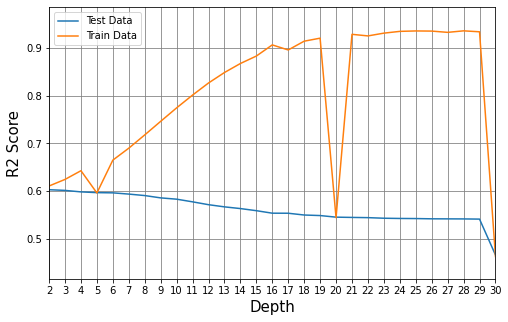

In [45]:
# Lineplot Visualization
viz(depth_list)

Here we see an interesting visual, where the scores seem to align most at depths 5, 20, and 30.

Depth 5 is too low while at depth 30 it looks like the model is failing and crashing, I will choose depth 20 as the best option, despite having a lower score than at depth 5.

In [47]:
# List of num of features
max_feat = list(range(5, 30))
# Scores DataFrame
scores = pd.DataFrame(index=max_feat, columns=['Test Score', 'Train Score'])
# Run mod function
mod(RandomForestRegressor, max_feat)

In [48]:
scores=scores.sort_values(by='Test Score', ascending=False)
scores.head()

,Test Score,Train Score
10,0.552664,0.937072
15,0.552514,0.937273
11,0.549646,0.936862
18,0.548946,0.936879
16,0.548701,0.937513


The max features seem to peak at 10, I will use this for the final model

# Conclusion

In [55]:
# Instantiate
rf = RandomForestRegressor(max_depth=20, max_features=10, n_estimators=130, random_state=42)
# Pipeline
rf_pipe = make_pipeline(preprocessor, rf)
# Fit model to Data
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7efe75301050>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7efe75301090>)])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=20, max_features=10,
                                       n_estimators=130, random_state=42))])

In [56]:
# Predictions
train_pred = rf_pipe.predict(X_train)
test_pred = rf_pipe.predict(X_test)

In [57]:
# Evaluation
eval(y_train, train_pred, 'Train Data')
eval(y_test, test_pred, 'Test Data')

Train Data
    MAE Score: 374.25339664168166
    MSE Score: 280941.41601202945
    RMSE Score: 530.0390702693807
    R2 Score: 0.9050699033669188
    
Test Data
    MAE Score: 762.959466518153
    MSE Score: 1202543.1069841476
    RMSE Score: 1096.6052648898544
    R2 Score: 0.5641344666740076
    


# Final Thoughts

I believe the Linear Regreesion model to be the better option for predicting this data.

My reasoning resides on how it performed against a Random Tree Regression Model.

The Random Tree Regression model kept overfitting even after I made adjustments by a significant margin.
The closer I tried make the R2 scores for the Training data and Test data, the worse the score had to get.
On the heatmap in my Predictions file you can see there is very little correlation with any of the numerical columns
The categorical columns don't assist much in putting it all together, ultimately just creating too much noise for the 
Tree Regression Model to effectively work with other forms of data.


The linear regression model managed to keep the R2 scores close together and overall higher than when the same was 
accomplished with the Tree Regression Model.